In [1]:
import tensorflow as tf
import numpy as np

import model.cnn as cnn
import model.rnn as rnn
import model.classifier as classifier

import data.ops

import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size = tf.placeholder_with_default(5, [])
input_op, seq_len, label, weight = data.ops.get_batch_ops(batch_size=batch_size, path='./data/small.TFRecord')

c = cnn.get_output(seq_len=seq_len, input_op=input_op)
r = rnn.get_model(batch_size=batch_size, seq_len=seq_len, input_op=c)
logits, pred = classifier.get_logits_and_pred(input_op=r.last_output)


CNN--cnn512x128-1024x64-1024x32
Tensor("CNN/conv_module/MaxPool2D/MaxPool:0", shape=(?, ?, 1, 512), dtype=float32)
Tensor("CNN/conv_module/MaxPool2D_1/MaxPool:0", shape=(?, ?, 1, 1024), dtype=float32)
Tensor("CNN/conv_module/MaxPool2D_2/MaxPool:0", shape=(?, ?, 1, 1024), dtype=float32)

RNN--rnn--steps300--sizes10-10-10
LSTMStateTuple(c=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_2:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_3:0' shape=(?, 10) dtype=float32>)
LSTMStateTuple(c=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_4:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_5:0' shape=(?, 10) dtype=float32>)
LSTMStateTuple(c=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_6:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_7:0' shape=(?, 10) dtype=float32>)

FC--fc30-10
Tensor("classifier/fully_connected/fully_connected/Relu:0", shape=(?, 30), dtype=floa

In [3]:
# Test Parameters
def measure_time(op):
    with tf.Session() as sess:
        print('Sess started')
        coord = tf.train.Coordinator()
        tf.global_variables_initializer().run()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        
        init_state = sess.run(r.zero_state)
        feed_dict = {r.init_state : init_state}
        print('Evaluating')
        for _ in range(10):
            t = time.time()
            test_output = sess.run(op, feed_dict)
            print(_, 'Eval time:', time.time() - t)
            
        print('Closing threads')
        coord.request_stop()
        coord.join(threads)
        sess.close()

        return test_output



In [4]:
for res in measure_time([input_op, c, r.last_output, logits]):
    print(res.shape)

Sess started
Evaluating
0 Eval time: 2.2510766983032227
1 Eval time: 3.191248893737793
2 Eval time: 0.4660067558288574
3 Eval time: 2.0613129138946533
4 Eval time: 0.8968346118927002
5 Eval time: 0.8959476947784424
6 Eval time: 0.8995277881622314
7 Eval time: 0.9530057907104492
8 Eval time: 0.612781286239624
9 Eval time: 0.8904471397399902
Closing threads
(5, 18000)
(5, 281, 1024)
(5, 10)
(5, 4)


In [6]:
measure_time(pred)

Sess started
Evaluating
0 Eval time: 1.776977300643921
1 Eval time: 2.253305196762085
2 Eval time: 0.25592756271362305
3 Eval time: 0.509739875793457
4 Eval time: 1.3434457778930664
5 Eval time: 0.520338773727417
6 Eval time: 0.26862430572509766
7 Eval time: 0.5079102516174316
8 Eval time: 0.5111587047576904
9 Eval time: 0.2695624828338623
Closing threads


array([[ 0.25890729,  0.24166726,  0.24019167,  0.2592338 ],
       [ 0.26369718,  0.24985258,  0.25308973,  0.23336054],
       [ 0.25356928,  0.22728491,  0.28090623,  0.23823956],
       [ 0.25      ,  0.25      ,  0.25      ,  0.25      ],
       [ 0.24970067,  0.24986887,  0.249942  ,  0.25048843]], dtype=float32)

In [8]:
measure_time(pred)

Sess started
Evaluating
0 Eval time: 7.421394109725952
1 Eval time: 7.293898105621338
2 Eval time: 18.217700242996216
3 Eval time: 14.83894681930542
4 Eval time: 7.6599202156066895
5 Eval time: 7.667870759963989
6 Eval time: 11.853241682052612
7 Eval time: 7.3040595054626465
8 Eval time: 7.190427541732788
9 Eval time: 7.439091205596924
Closing threads


array([[ 0.23965174,  0.26775464,  0.23852685,  0.2540668 ],
       [ 0.25234219,  0.24551241,  0.25425261,  0.24789278],
       [ 0.24090105,  0.25122231,  0.25718123,  0.25069538]], dtype=float32)

In [ ]:
multi_times = []
for _ in range(5):
    conv_times = []
    for batch in [2**i for i in range(9)]:
        t = measure_conv_time(batch)
        print(batch, t)
        conv_times.append(t/batch)
    multi_times.append(conv_times)

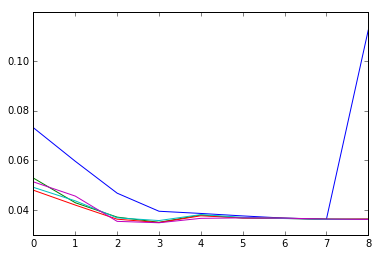

In [24]:
np_multi_times = np.array(multi_times).T
plt.plot(np_multi_times)

In [6]:
test_output

array([[ 0.24823149,  0.26793534,  0.2448772 ,  0.238956  ],
       [ 0.24495746,  0.26279256,  0.26794887,  0.22430106],
       [ 0.22878198,  0.25089762,  0.28999823,  0.23032229],
       [ 0.24629396,  0.23979738,  0.26271954,  0.25118902],
       [ 0.2437077 ,  0.25369841,  0.2505379 ,  0.252056  ]], dtype=float32)

# CNN inspection

In [1]:
import tensorflow as tf
import numpy as np
import cnn

In [2]:
c = cnn.model()


CNN--cnn512x128-1024x64
Tensor("CNN/conv_module/Conv/Relu:0", shape=(?, ?, 512), dtype=float32)
Tensor("CNN/conv_module/Conv_1/Relu:0", shape=(?, ?, 1024), dtype=float32)


In [3]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


<tf.Tensor 'CNN/conv_module/dropout_1/mul:0' shape=(?, ?, 1024) dtype=float32>

In [5]:
c.output.eval({c.input:np.random.randn(5, 1000)})

array([[[ 0.        ,  1.15490937,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.93614274, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.26819906, ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  1.18496716,
          1.85945785,  0.60171425],
        [ 0.        ,  0.        ,  0.        , ...,  0.76500356,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.68281138, ...,  0.        ,
          0.        ,  0.41156232]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.10739088,  0.        ,  0.        , ...,  0.69967657,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,

# RNN inspection

In [1]:
import tensorflow as tf
import numpy as np
import rnn

In [2]:
r = rnn.stackedLSTM()
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


RNN--rnn--steps300--sizes10-10-10
LSTMStateTuple(c=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_2:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_3:0' shape=(?, 10) dtype=float32>)
LSTMStateTuple(c=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_4:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_5:0' shape=(?, 10) dtype=float32>)
LSTMStateTuple(c=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_6:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'RNN/LSTM/dynamic_wrapper/rnn/while/Exit_7:0' shape=(?, 10) dtype=float32>)


In [6]:
# Test Parameters
batch_size = 5
max_seq_len = 1000

init_state = sess.run(r.zero_state, {r.batch_size:batch_size})
feed_dict = {
    r.input : np.random.randn(batch_size, max_seq_len), 
    r.seq_len : [1, 2, 3, 4, 5],
    r.init_state : init_state,
    r.batch_size : batch_size}

test_output = r.last_output.eval(feed_dict)

NameError: name 'pred' is not defined